# Confirming MSD statistics for (+) chemotaxis and (-) chemotaxis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
import numpy as np
from pathlib import Path

# Prefer using helper from src if available; fallback to local implementation
try:
    import sys
    repo_root = Path(__file__).resolve().parents[2]
    sys.path.append(str(repo_root / "src"))
    from helper import compute_msd_fft  # type: ignore
except Exception:
    def _autocorr_fft_1d(x):
        x = np.asarray(x, dtype=np.float64)
        M = x.shape[0]
        nfft = 1 << (2*M - 1).bit_length()
        xp = np.zeros(nfft, dtype=np.float64)
        xp[:M] = x
        F = np.fft.rfft(xp)
        S = F * np.conj(F)
        acf = np.fft.irfft(S, nfft)[:M].real
        return acf

    def msd_fft_single(r):
        r = np.asarray(r, dtype=np.float64)
        if r.ndim == 1:
            r = r[:, None]
        M, d = r.shape
        acf_dot = np.zeros(M, dtype=np.float64)
        for k in range(d):
            acf_dot += _autocorr_fft_1d(r[:, k])
        rsq = np.sum(r*r, axis=1)
        csum = np.concatenate(([0.0], np.cumsum(rsq)))
        taus = np.arange(M)
        counts = (M - taus).astype(np.float64)
        sum_rsq_t     = csum[M - taus] - csum[0]
        sum_rsq_t_tau = csum[M] - csum[taus]
        msd = (sum_rsq_t + sum_rsq_t_tau - 2.0 * acf_dot) / counts
        return msd

    def compute_msd_fft(positions, max_lag=None, stride=1, average=True):
        pos = np.asarray(positions, dtype=np.float64)
        assert pos.ndim == 3, "positions must be (N, M, d)"
        N, M, d = pos.shape
        pos = pos[:, ::stride, :]
        M = pos.shape[1]
        L = M if max_lag is None else int(min(max_lag, M-1)) + 1
        out = np.empty((N, L), dtype=np.float64)
        for n in range(N):
            msd_full = msd_fft_single(pos[n])
            out[n] = msd_full[:L]
        return out.mean(axis=0) if average else out


In [ ]:
from pathlib import Path
POS_PATH = str(Path.cwd().parents[0] / "data" / "RR" / "sink1_5" / "pos" / "n1000_t1000_pos_RR_nobind515_mag0.npy")

In [12]:
dt = 0.002   # <-- use your sim's timestep
pos_nochemo = np.load(POS_PATH)              # (T, N, 3)
msd_nochemo = compute_msd_fft(pos_nochemo.swapaxes(0,1), stride=10, average=True)

# Build time array
L = msd_nochemo.shape[0]
times = np.arange(L) * dt * 10   # factor 10 since stride=10 above

In [ ]:
from pathlib import Path
WCHEMOPATH = str(Path.cwd().parents[0] / "data" / "RR" / "sink1_5" / "pos" / "n1000_t1000_pos_RR_bind515_mag0.npy")

In [6]:
dt = 0.002   # <-- use your sim's timestep
pos_wchemo = np.load(WCHEMOPATH)              # (T, N, 3)
msd_wchemo = compute_msd_fft(pos_wchemo.swapaxes(0,1), stride=10, average=True)

# Build time array
L = msd_wchemo.shape[0]
times = np.arange(L) * dt * 10   # factor 10 since stride=10 above

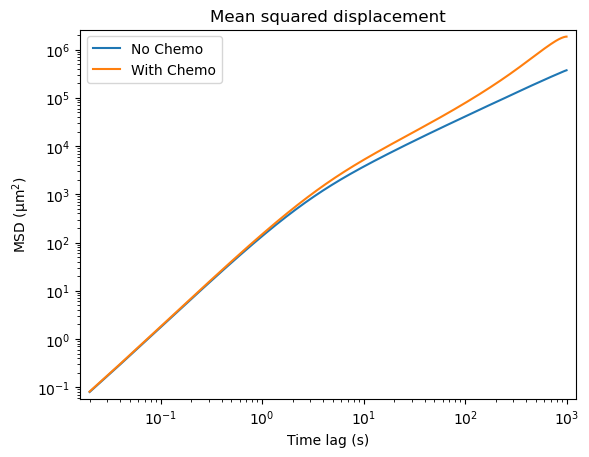

In [ ]:
# Convert y-axis from m^2 to µm^2
msd_nochemo_um2 = msd_nochemo * 1e12
msd_wchemo_um2 = msd_wchemo * 1e12

plt.figure(figsize=(6,4))
plt.loglog(times[1:], msd_nochemo_um2[1:], label='No Chemo')
plt.loglog(times[1:], msd_wchemo_um2[1:], label='With Chemo')
plt.legend()
plt.xlabel("Time lag (s)")
plt.ylabel("MSD (µm$^2$)")
plt.title("Mean squared displacement")
plt.autoscale(tight=True); plt.margins(0.02, 0.02)
plt.tight_layout()
plt.show()